## **1. Regression on the data set**

Registering To Kaggle API

In [61]:
import json
import os

!mkdir /root/.kaggle/
# Installing the Kaggle package


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Downloading the Football Players Data

In [ ]:
!mkdir ./datasets/football-players-data
!kaggle datasets download maso0dahmed/football-players-data -p ./datasets/football-players-data
!unzip ./datasets/football-players-data/*.zip  -d ./datasets/football-players-data/

mkdir: cannot create directory ‘./datasets/football-players-data’: No such file or directory
Dataset URL: https://www.kaggle.com/datasets/maso0dahmed/football-players-data
License(s): apache-2.0
  0% 0.00/1.24M [00:00<?, ?B/s]
100% 1.24M/1.24M [00:00<00:00, 60.6MB/s]
Archive:  ./datasets/football-players-data/football-players-data.zip
  inflating: ./datasets/football-players-data/fifa_players.csv  


Load Football Players Data into Pandas Dataframe.

In [ ]:
import pandas as pd
df = pd.read_csv('./datasets/football-players-data/fifa_players.csv', encoding= 'unicode_escape')
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel AndrÃ©s Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


Convert value_euro to millions for easier interpretation

In [ ]:
df['value_million_euro'] = df['value_euro'] / 1000000
df.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,value_million_euro
0,L. Messi,Lionel AndrÃ©s Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,48,22,94,94,75,96,33,28,26,110.5
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,46,56,84,91,67,88,59,57,22,69.5
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,78,64,82,88,82,87,63,67,67,73.0
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,34,26,83,87,61,83,51,24,22,62.0
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,87,88,24,49,33,80,91,88,87,60.0


Feature Engineering

In [ ]:
import numpy as np
df['age_bracket'] = pd.cut(df['age'], bins=[0, 23, 28, 32, 100], labels=[0, 1, 2, 3])
df['potential_vs_overall'] = df['potential'] - df['overall_rating']

Select features

In [ ]:
from sklearn.impute import SimpleImputer
features = ['age_bracket', 'potential_vs_overall', 'overall_rating', 'wage_euro',
            'international_reputation(1-5)', 'release_clause_euro'] + \
           [col for col in df.columns if col.endswith(('crossing', 'finishing', 'heading_accuracy',
                                                      'short_passing', 'volleys', 'dribbling', 'curve',
                                                      'freekick_accuracy', 'long_passing', 'ball_control'))]

X = df[features]
y = df['value_euro']

Handle NaN values in the target variable

In [ ]:
y = y.fillna(y.median())

Log-transform the target variable after handling NaN values

In [ ]:
y = np.log1p(y)

Split the data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create a preprocessing pipeline

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['age_bracket']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ]), categorical_features)
    ])

Create a pipeline with preprocessor and random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

Fit the pipeline

In [ ]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['potential_vs_overall', 'overall_rating', 'wage_euro',
       'international_reputation(1-5)', 'release_clause_euro', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['age_bracket'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Make predictions

In [ ]:
y_pred = rf_pipeline.predict(X_test)

Evaluate the model

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Root Mean Squared Error (log scale): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

Model Evaluation:
Root Mean Squared Error (log scale): 0.1043
R-squared Score: 0.9945


Feature importance

In [ ]:
feature_importance = pd.DataFrame({'feature': features,
                                   'importance': rf_pipeline.named_steps['regressor'].feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                          feature  importance
1            potential_vs_overall    0.660801
4   international_reputation(1-5)    0.316189
15                   ball_control    0.008965
2                  overall_rating    0.004157
0                     age_bracket    0.003900
6                        crossing    0.001397
9                   short_passing    0.000667
10                        volleys    0.000575
14                   long_passing    0.000522
13              freekick_accuracy    0.000521


Example prediction

In [ ]:
example_player = X_test.iloc[0:1]
predicted_value = np.expm1(rf_pipeline.predict(example_player)[0])
actual_value = np.expm1(y_test.iloc[0])

print("\nExample Prediction:")
print(f"Predicted Value: {predicted_value:.2f} euros")
print(f"Actual Value: {actual_value:.2f} euros")


Example Prediction:
Predicted Value: 430202.73 euros
Actual Value: 425000.00 euros


Print feature values for the example player

In [ ]:
print("\nFeature values for the example player:")
for feature, value in example_player.iloc[0].items():
    print(f"{feature}: {value:.2f}")


Feature values for the example player:
age_bracket: 2.00
potential_vs_overall: 0.00
overall_rating: 64.00
wage_euro: 2000.00
international_reputation(1-5): 1.00
release_clause_euro: 744000.00
crossing: 65.00
finishing: 63.00
heading_accuracy: 67.00
short_passing: 58.00
volleys: 65.00
dribbling: 60.00
curve: 66.00
freekick_accuracy: 62.00
long_passing: 53.00
ball_control: 63.00


Predict the value_euro using a Knn regressor


In [ ]:
# prompt: Predict the value_euro using a Knn regressor

from sklearn.neighbors import KNeighborsRegressor

# Create a pipeline with preprocessor and KNN regressor
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5))  # You can adjust n_neighbors
])

# Fit the pipeline
knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_pipeline.predict(X_test)

# Evaluate the model
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("\nKNN Model Evaluation:")
print(f"Root Mean Squared Error (log scale): {rmse_knn:.4f}")
print(f"R-squared Score: {r2_knn:.4f}")



KNN Model Evaluation:
Root Mean Squared Error (log scale): 0.3352
R-squared Score: 0.9435


Example prediction

In [ ]:
# prompt: Example prediction

# Example prediction for KNN
example_player_knn = X_test.iloc[0:1]
predicted_value_knn = np.expm1(knn_pipeline.predict(example_player_knn)[0])
actual_value_knn = np.expm1(y_test.iloc[0])

print("\nKNN Example Prediction:")
print(f"Predicted Value: {predicted_value_knn:.2f} euros")
print(f"Actual Value: {actual_value_knn:.2f} euros")



KNN Example Prediction:
Predicted Value: 483981.90 euros
Actual Value: 425000.00 euros


Prdecit the value_euro with Support Vector Regression (SVR)

In [ ]:
# prompt: Prdecit the value_euro with Support Vector Regression (SVR)

from sklearn.svm import SVR

# Create a pipeline with preprocessor and SVR
svr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))  # You can try different kernels
])

# Fit the pipeline
svr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_pipeline.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSVR Model Evaluation:")
print(f"Root Mean Squared Error (log scale): {rmse_svr:.4f}")
print(f"R-squared Score: {r2_svr:.4f}")

# Example prediction for SVR
example_player_svr = X_test.iloc[0:1]
predicted_value_svr = np.expm1(svr_pipeline.predict(example_player_svr)[0])
actual_value_svr = np.expm1(y_test.iloc[0])

print("\nSVR Example Prediction:")
print(f"Predicted Value: {predicted_value_svr:.2f} euros")
print(f"Actual Value: {actual_value_svr:.2f} euros")



SVR Model Evaluation:
Root Mean Squared Error (log scale): 0.2335
R-squared Score: 0.9726

SVR Example Prediction:
Predicted Value: 372116.10 euros
Actual Value: 425000.00 euros


Predict the value_euro with Linear Regression

In [ ]:
# prompt: Predict the value_euro with Linear Regression

from sklearn.linear_model import LinearRegression

# Create a pipeline with preprocessor and Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Model Evaluation:")
print(f"Root Mean Squared Error (log scale): {rmse_lr:.4f}")
print(f"R-squared Score: {r2_lr:.4f}")

# Example prediction for Linear Regression
example_player_lr = X_test.iloc[0:1]
predicted_value_lr = np.expm1(lr_pipeline.predict(example_player_lr)[0])
actual_value_lr = np.expm1(y_test.iloc[0])

print("\nLinear Regression Example Prediction:")
print(f"Predicted Value: {predicted_value_lr:.2f} euros")
print(f"Actual Value: {actual_value_lr:.2f} euros")



Linear Regression Model Evaluation:
Root Mean Squared Error (log scale): 0.2984
R-squared Score: 0.9552

Linear Regression Example Prediction:
Predicted Value: 370114.09 euros
Actual Value: 425000.00 euros


Predict the value_euro with Decistion Tree

In [ ]:
# prompt: Predict the value_euro with Decistion Tree

from sklearn.tree import DecisionTreeRegressor

# Create a pipeline with preprocessor and Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))  # You can adjust hyperparameters
])

# Fit the pipeline
dt_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_pipeline.predict(X_test)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("\nDecision Tree Model Evaluation:")
print(f"Root Mean Squared Error (log scale): {rmse_dt:.4f}")
print(f"R-squared Score: {r2_dt:.4f}")

# Example prediction for Decision Tree
example_player_dt = X_test.iloc[0:1]
predicted_value_dt = np.expm1(dt_pipeline.predict(example_player_dt)[0])
actual_value_dt = np.expm1(y_test.iloc[0])

print("\nDecision Tree Example Prediction:")
print(f"Predicted Value: {predicted_value_dt:.2f} euros")
print(f"Actual Value: {actual_value_dt:.2f} euros")



Decision Tree Model Evaluation:
Root Mean Squared Error (log scale): 0.1511
R-squared Score: 0.9885

Decision Tree Example Prediction:
Predicted Value: 425000.00 euros
Actual Value: 425000.00 euros


## **2. Predict value_euro**

Load the data to new variables.

In [ ]:
df2 = df.copy()
df2.head()
df2.columns

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle',
       'value_million_euro', 'age_bracket', 'potential_vs_overall'],
      dtype='object')

Prepare the data

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

features = ['age', 'overall_rating', 'potential', 'wage_euro', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle']

target = ['value_euro']

#Handle missing values
df2 = df.dropna(subset=features + target)

#Categorizing the value_euro
bins = [0, 1e6, 5e6, 10e6, 50e6, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
X2 = df2[features]
y2 = df2[target]
y2_categorial = pd.cut(y2['value_euro'], bins=bins, labels=labels)

#Select the best 10 features to minimize features
selector = SelectKBest(f_classif, k=10)
X2_selected = selector.fit_transform(X2, y2_categorial)
selected_features = X2.columns[selector.get_support()].tolist()

X2_train_selected, X2_test_selected, y2_train, y2_test = train_test_split(X2_selected, y2_categorial, test_size=0.2, random_state=1)

Create a decision tree classifier using sklearn package and train a model based on the training set.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=1)
clf_tree.fit(X2_train_selected, y2_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=1)

Draw the tree obtained

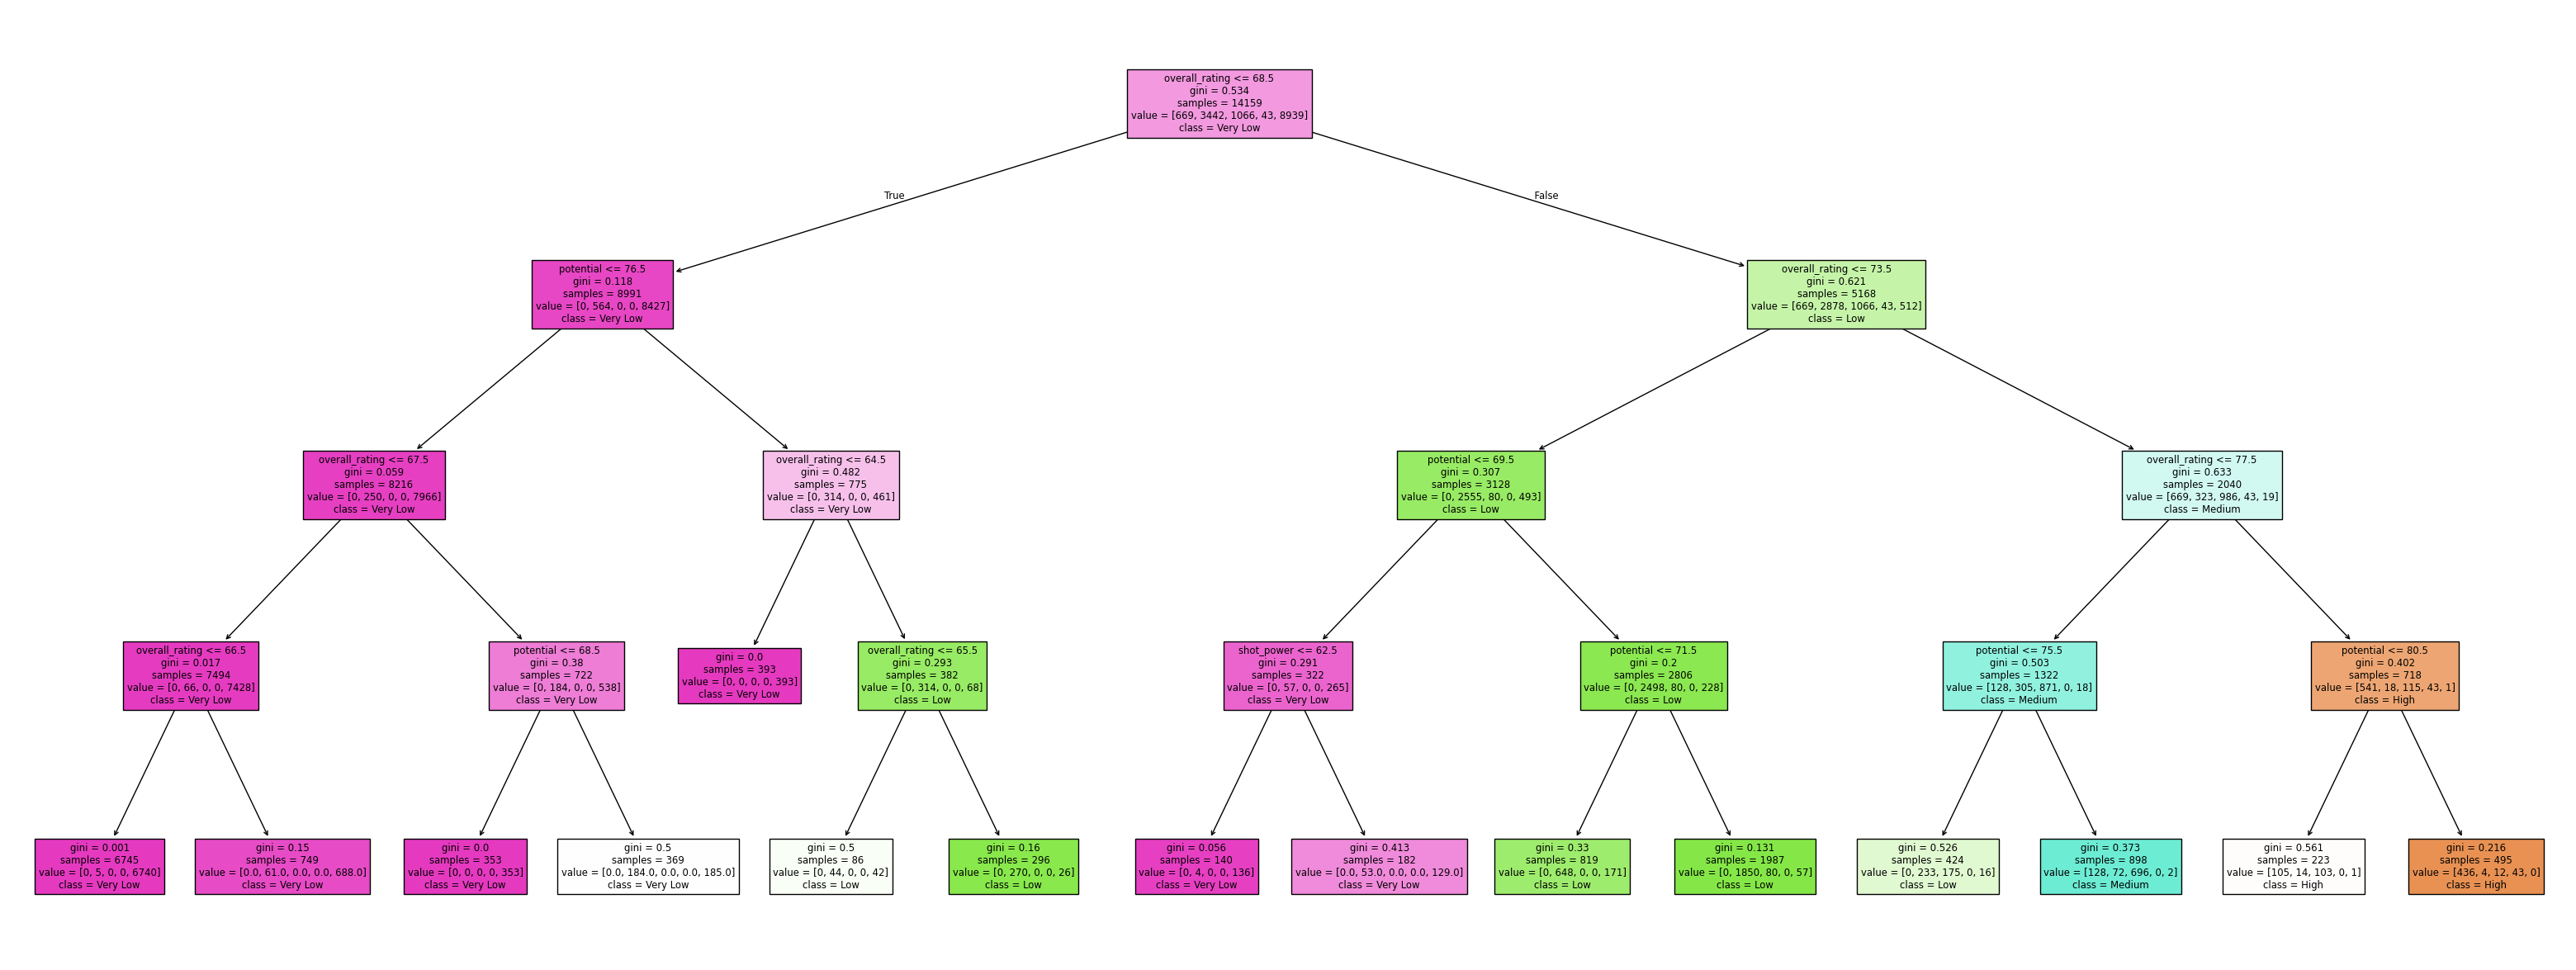

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
plt.figure(figsize=(40, 15))
tree.plot_tree(clf_tree, feature_names=selected_features, class_names=clf_tree.classes_, filled=True)
plt.show()

Evaluate the preformance of the trained classifier

In [ ]:
y_pred = clf_tree.predict(X2_test_selected)
y_pred

array(['Very Low', 'High', 'Very Low', ..., 'Very Low', 'Very Low',
       'Very Low'], dtype=object)

Evaluate the prediction by using accuracy mesaure

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y2_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


Checking the classifier for overfitting

In [ ]:
y_train_pred = clf_tree.predict(X2_train_selected)
train_accuracy = accuracy_score(y2_train, y_train_pred)
print("Training Accuracy: ", train_accuracy)

if train_accuracy - accuracy > 0.1:
  print("The classifier is overfitting")
else:
  print("The classifier is not overfitting")

print(f"Overfitting result: {train_accuracy - accuracy}")

Training Accuracy:  0.9115050497916519
The classifier is not overfitting
Overfitting result: -0.0026192439936587597


Example for player

In [ ]:
random_index = np.random.randint(0, len(X2_test_selected))
example_player = X2_test_selected[random_index]

example_player_reshaped = example_player.reshape(1, -1)

predicted_category = clf_tree.predict(example_player_reshaped)[0]

print(f"Predicted Value Category for the Example Player: {predicted_category}")

actual_category = y2_test.iloc[random_index]
print(f"Actual Value Category for the Example Player: {actual_category}")


Predicted Value Category for the Example Player: Low
Actual Value Category for the Example Player: Low


Use the KNN to check the accuracy of the training/test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X2_train_selected, y2_train)
y_pred_knn = knn.predict(X2_test_selected)
accuracy_knn = accuracy_score(y2_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.2f}")
y_train_pred_knn = knn.predict(X2_train_selected)
train_accuracy_knn = accuracy_score(y2_train, y_train_pred_knn)
print("KNN Training Accuracy: ", train_accuracy_knn)

if train_accuracy_knn - accuracy_knn > 0.1:
  print("The KNN classifier is overfitting")
else:
  print("The KNN classifier is not overfitting")

print(f"Overfitting result: {train_accuracy_knn - accuracy_knn}")

KNN Accuracy: 0.82
KNN Training Accuracy:  0.8832544671233844
The KNN classifier is not overfitting
Overfitting result: 0.06065559706688728


Example for a player

In [ ]:
random_index = np.random.randint(0, len(X2_test_selected))
example_player = X2_test_selected[random_index]

example_player_reshaped = example_player.reshape(1, -1)

predicted_category_knn = knn.predict(example_player_reshaped)[0]

print(f"KNN Predicted Value Category for the Example Player: {predicted_category_knn}")

actual_category = y2_test.iloc[random_index]
print(f"Actual Value Category for the Example Player: {actual_category}")

KNN Predicted Value Category for the Example Player: Medium
Actual Value Category for the Example Player: Medium


Use the SVM to check the accuracy of the training and test

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

all_labels = np.unique(np.concatenate((y2_train, y2_test)))
le = LabelEncoder()
le.fit(all_labels)

y_train_encoded = le.transform(y2_train)
y_test_encoded = le.transform(y2_test)

svm = LinearSVC(random_state=42, max_iter=5000)
svm.fit(X2_train_selected, y_train_encoded)

y_pred_encoded = svm.predict(X2_test_selected)
y_pred = le.inverse_transform(y_pred_encoded)
test_accuracy = accuracy_score(y2_test, y_pred)
print(f"SVM Test Accuracy: {test_accuracy:.4f}")

y_train_pred_encoded = svm.predict(X2_train_selected)
y_train_pred = le.inverse_transform(y_train_pred_encoded)
train_accuracy = accuracy_score(y2_train, y_train_pred)
print(f"SVM Training Accuracy: {train_accuracy:.4f}")

if train_accuracy - test_accuracy > 0.1:
    print("The SVM classifier might be overfitting.")
else:
    print("The SVM classifier does not show signs of significant overfitting.")

print(f"Overfitting result: {train_accuracy - test_accuracy}")

SVM Test Accuracy: 0.7268
SVM Training Accuracy: 0.7212
The SVM classifier does not show signs of significant overfitting.
Overfitting result: -0.005669409127890934


Example player

In [ ]:
random_index = np.random.randint(0, len(X2_test_selected))
example_player = X2_test_selected[random_index]

example_player_reshaped = example_player.reshape(1, -1)

predicted_category_encoded = svm.predict(example_player_reshaped)[0]
predicted_category = le.inverse_transform([predicted_category_encoded])[0]

print(f"SVM Predicted Value Category for the Example Player: {predicted_category}")

actual_category = y2_test.iloc[random_index]
print(f"Actual Value Category for the Example Player: {actual_category}")


SVM Predicted Value Category for the Example Player: Very Low
Actual Value Category for the Example Player: Low


Use XGBoost to predict value_euros and check the accuracy

In [ ]:
import xgboost as xgb

le = LabelEncoder()
y2_train_encoded = le.fit_transform(y2_train)
y2_test_encoded = le.transform(y2_test)

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(le.classes_), random_state=42)
xgb_model.fit(X2_train_selected, y2_train_encoded)

y_pred_encoded = xgb_model.predict(X2_test_selected)
y_pred = le.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y2_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")

y_train_pred_encoded = xgb_model.predict(X2_train_selected)
y_train_pred = le.inverse_transform(y_train_pred_encoded)
train_accuracy = accuracy_score(y2_train, y_train_pred)
print("XGBoost Training Accuracy: ", train_accuracy)

if train_accuracy - accuracy > 0.1:
    print("The XGBoost classifier might be overfitting.")
else:
    print("The XGBoost classifier does not show signs of significant overfitting.")

print(f"Overfitting result: {train_accuracy - accuracy}")


XGBoost Accuracy: 0.95
XGBoost Training Accuracy:  0.9991524825199519
The XGBoost classifier does not show signs of significant overfitting.
Overfitting result: 0.05141236952560169


Player example

In [ ]:
random_index = np.random.randint(0, len(X2_test_selected))
example_player = X2_test_selected[random_index]

example_player_reshaped = example_player.reshape(1, -1)

predicted_category_encoded = xgb_model.predict(example_player_reshaped)[0]
predicted_category = le.inverse_transform([predicted_category_encoded])[0]

print(f"XGBoost Predicted Value Category for the Example Player: {predicted_category}")

actual_category = y2_test.iloc[random_index]
print(f"Actual Value Category for the Example Player: {actual_category}")


XGBoost Predicted Value Category for the Example Player: Medium
Actual Value Category for the Example Player: Low


Use Naive Bayes to predict the value_euro (m-estimate)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Create Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gnb, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the average accuracy
average_accuracy = cv_scores.mean()
print("Average accuracy:", average_accuracy)

# Fit the model on the training data
gnb.fit(X2_test_selected, y2_test)

# Predict on the test set
y_pred2 = gnb.predict(X2_test_selected)

# Calculate accuracy
accuracy = accuracy_score(y2_test, y_pred2)
print("Accuracy:", accuracy)

Cross-validation scores: [0.89745763 0.77655367 0.8059322  0.9299435  0.75218988]
Average accuracy: 0.8324153779595564
Accuracy: 0.8516949152542372


## 3. **Predict wage_euros**

In [ ]:
def create_unique_bins(data, n_bins=6):
    """Create unique bin edges based on percentiles."""
    percentiles = np.linspace(0, 100, n_bins + 1)
    bins = np.unique(np.percentile(data, percentiles))

    # Ensure the last bin edge is infinity
    if bins[-1] != np.inf:
        bins = np.append(bins, np.inf)

    return bins

Load the data to variables

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

df3 = df.copy()
df3.head()

,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle,value_million_euro,age_bracket,potential_vs_overall
0,L. Messi,Lionel AndrÃ©s Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,94,75,96,33,28,26,110.5,2,0
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,84,91,67,88,59,57,22,69.5,1,1
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,88,82,87,63,67,67,73.0,1,3
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,83,87,61,83,51,24,22,62.0,1,0
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,24,49,33,80,91,88,87,60.0,1,3


Selecting features

In [ ]:
features = ['age', 'overall_rating', 'potential', 'value_euro', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle']

target = 'wage_euro'

Handle missing values

In [ ]:
df3 = df3.dropna(subset=features + [target])

Categorizing the wage_euro

In [ ]:
bins = [0, 10000, 50000, 100000, 200000, np.inf]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
X = df3[features]
y = pd.cut(df3[target], bins=bins, labels=labels)

Select the best 20 features to minimize features

In [ ]:
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()

Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Encode the labels

In [ ]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Train the XGBoost Classifier

In [ ]:
xgb_model = XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=200,
                          min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
                          random_state=1)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Make predictions

In [ ]:
y_pred_encoded = xgb_model.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)
y_pred

array(['Very Low', 'Low', 'Very Low', ..., 'Very Low', 'Very Low',
       'Very Low'], dtype=object)

Evaluate the model

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8754


Check for overfitting

In [ ]:
y_train_pred_encoded = xgb_model.predict(X_train)
y_train_pred = le.inverse_transform(y_train_pred_encoded)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

if train_accuracy - accuracy > 0.1:
    print("The classifier is overfitting")
else:
    print("The classifier is not overfitting")

print(f"Overfitting result: {train_accuracy - accuracy}")

Training Accuracy: 0.9439
The classifier is not overfitting
Overfitting result: 0.06842823813325893


Player example

In [ ]:
random_index = np.random.randint(0, len(X_test))
example_player = X_test.iloc[random_index]

example_player_array = example_player.values.reshape(1, -1)  # Reshape for prediction

predicted_category_encoded = xgb_model.predict(example_player_array)[0]
predicted_category = le.inverse_transform([predicted_category_encoded])[0]

print(f"XGBoost Predicted Wage Category for the Example Player: {predicted_category}")

actual_category = y_test.iloc[random_index]
print(f"Actual Wage Category for the Example Player: {actual_category}")


XGBoost Predicted Wage Category for the Example Player: Very Low
Actual Wage Category for the Example Player: Very Low


Use the KNN to check the accuracy of the training/Test

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train_encoded)

y_pred_encoded = knn.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.4f}")

y_train_pred_encoded = knn.predict(X_train)
y_train_pred = le.inverse_transform(y_train_pred_encoded)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"KNN Training Accuracy: {train_accuracy:.4f}")

if train_accuracy - accuracy > 0.1:
    print("The KNN classifier is overfitting")
else:
    print("The KNN classifier is not overfitting")

print(f"Overfitting result: {train_accuracy - accuracy}")

KNN Accuracy: 0.8511
KNN Training Accuracy: 0.8933
The KNN classifier is not overfitting
Overfitting result: 0.042153480467794546


Player example

In [ ]:
random_index = np.random.randint(0, len(X_test))
example_player = X_test.iloc[random_index]

example_player_array = example_player.values.reshape(1, -1)  # Reshape for prediction

predicted_category_encoded = knn.predict(example_player_array)[0]
predicted_category = le.inverse_transform([predicted_category_encoded])[0]

print(f"KNN Predicted Wage Category for the Example Player: {predicted_category}")

actual_category = y_test.iloc[random_index]
print(f"Actual Wage Category for the Example Player: {actual_category}")


KNN Predicted Wage Category for the Example Player: Very Low
Actual Wage Category for the Example Player: Very Low


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Use the SVM to check the accuracy of the training and test

In [ ]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=42, max_iter=1000)
svm.fit(X_train, y_train_encoded)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Test Accuracy: {accuracy:.4f}")

y_train_pred_encoded = svm.predict(X_train)
y_train_pred = le.inverse_transform(y_train_pred_encoded)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"SVM Training Accuracy: {train_accuracy:.4f}")

if train_accuracy - accuracy > 0.1:
    print("The SVM classifier might be overfitting.")
else:
    print("The SVM classifier does not show signs of significant overfitting.")

print(f"Overfitting result: {train_accuracy - accuracy}")

SVM Test Accuracy: 0.8511
SVM Training Accuracy: 0.8412
The SVM classifier does not show signs of significant overfitting.
Overfitting result: -0.009968844555159118


Player example

In [ ]:
random_index = np.random.randint(0, len(X_test))
example_player = X_test.iloc[random_index]

example_player_array = example_player.values.reshape(1, -1)  # Reshape for prediction

predicted_category_encoded = svm.predict(example_player_array)[0]
predicted_category = le.inverse_transform([predicted_category_encoded])[0]

print(f"SVM Predicted Wage Category for the Example Player: {predicted_category}")

actual_category = y_test.iloc[random_index]
print(f"Actual Wage Category for the Example Player: {actual_category}")


SVM Predicted Wage Category for the Example Player: Very Low
Actual Wage Category for the Example Player: Very Low


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


Create a decision tree classifier using sklearn package and train a model based on the training set.

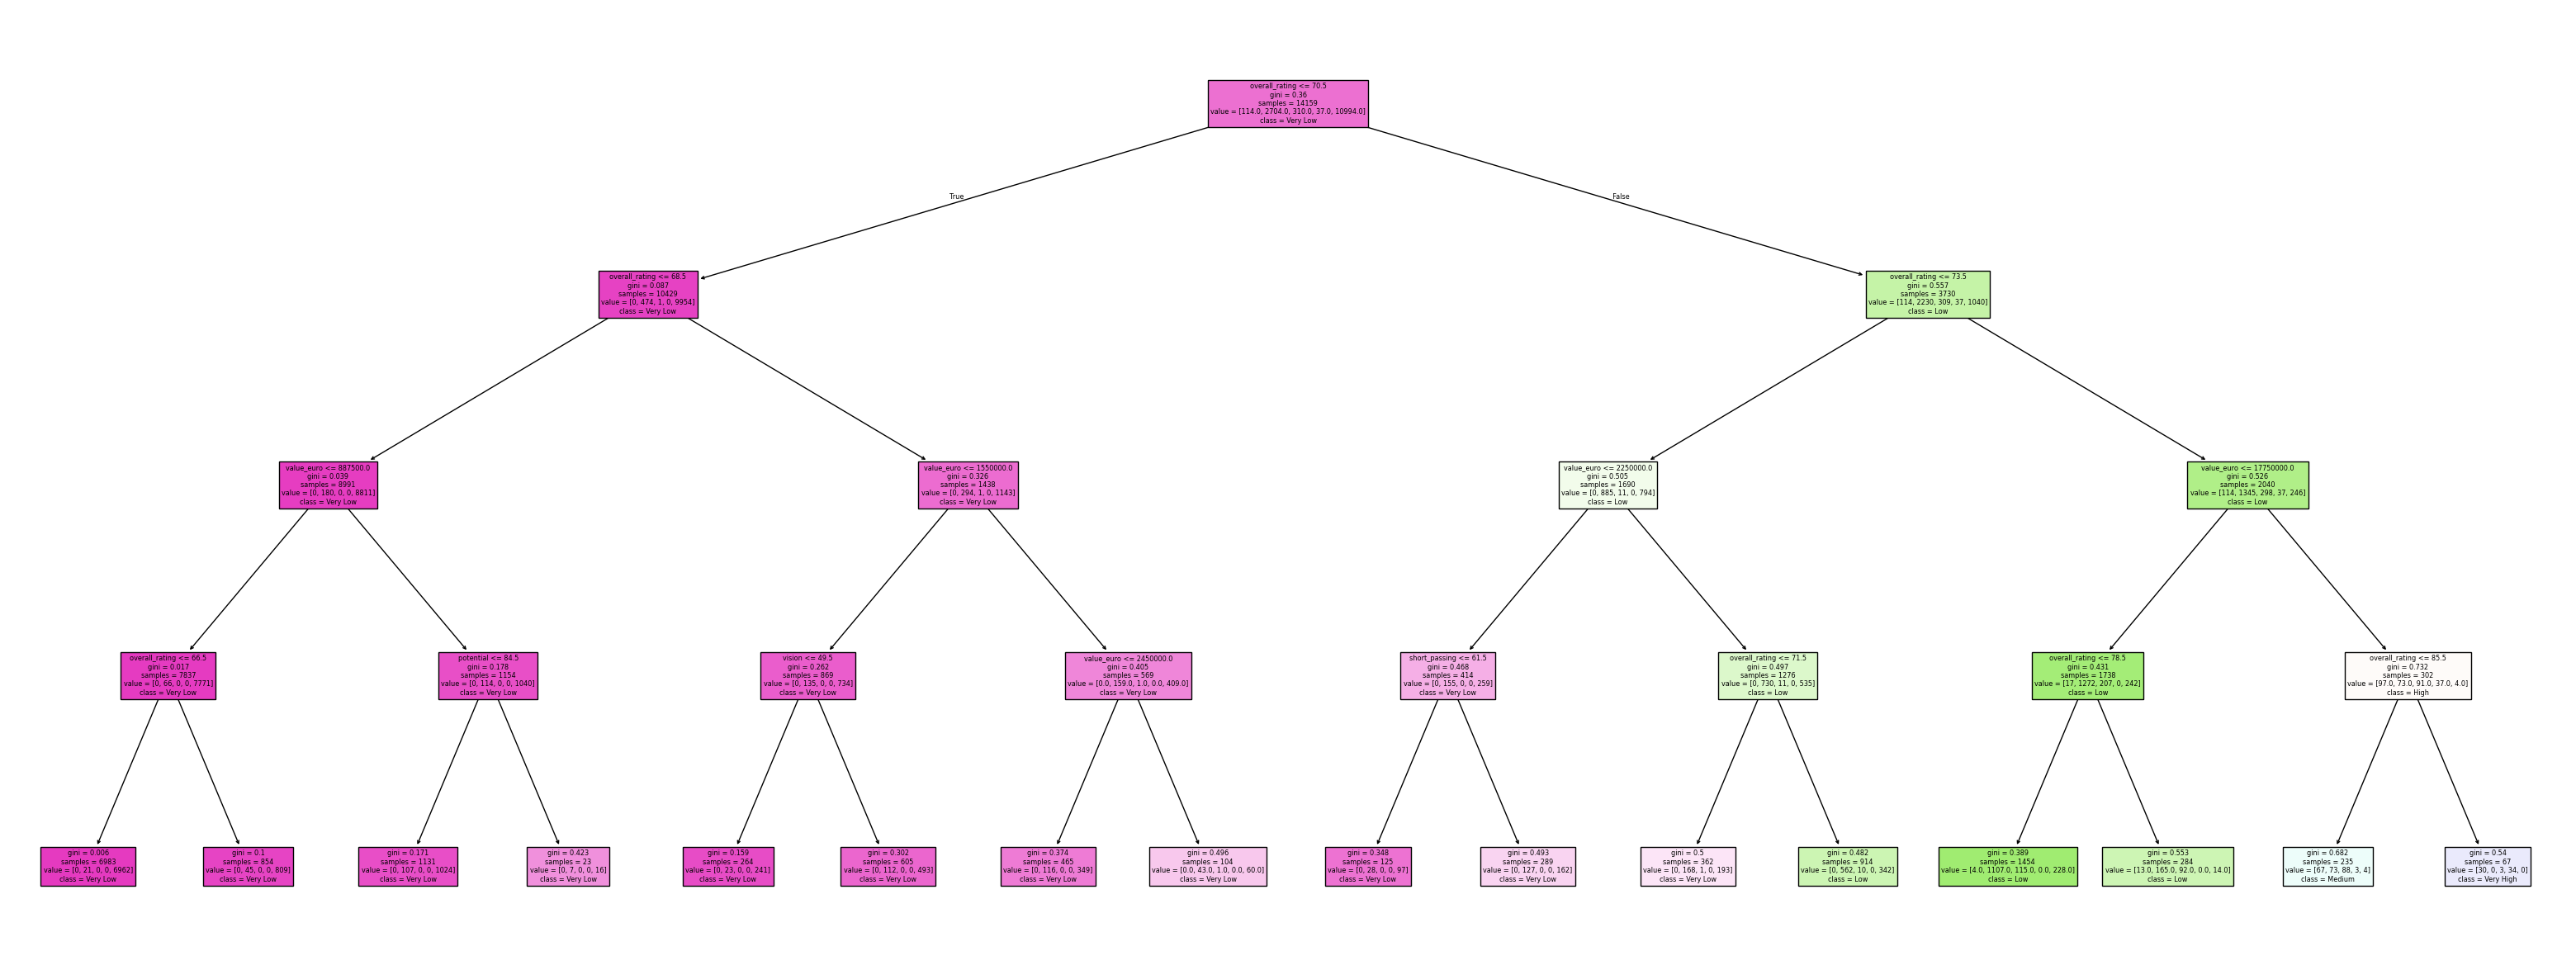

Accuracy: 0.87
Training Accuracy:  0.8730842573628081
The classifier is not overfitting
Overfitting result: -0.0017744996993387385


In [ ]:
X_wage_tree = df2[features]
y_wage_tree = df2[target]
y2_categorial = pd.cut(df2['wage_euro'], bins=bins, labels=labels)

#Select the best 10 features to minimize features
selector = SelectKBest(f_classif, k=10)
X2_selected_wage_tree = selector.fit_transform(X_wage_tree, y2_categorial)
selected_features = X_wage_tree.columns[selector.get_support()].tolist()

X2_train_selected_tree, X2_test_selected_tree, y2_train_tree, y2_test_tree = train_test_split(X2_selected_wage_tree, y2_categorial, test_size=0.2, random_state=1)

clf_tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, random_state=1)
clf_tree.fit(X2_train_selected_tree, y2_train_tree)
plt.figure(figsize=(40, 15))
tree.plot_tree(clf_tree, feature_names=selected_features, class_names=clf_tree.classes_, filled=True)
plt.show()

y_pred = clf_tree.predict(X2_test_selected_tree)
accuracy = accuracy_score(y2_test_tree, y_pred)
print(f"Accuracy: {accuracy:.2f}")

y_train_pred = clf_tree.predict(X2_train_selected_tree)
train_accuracy = accuracy_score(y2_train_tree, y_train_pred)
print("Training Accuracy: ", train_accuracy)

if train_accuracy - accuracy > 0.1:
  print("The classifier is overfitting")
else:
  print("The classifier is not overfitting")

print(f"Overfitting result: {train_accuracy - accuracy}")

Player example

In [ ]:
random_index = np.random.randint(0, len(X2_test_selected))
example_player = X2_test_selected[random_index]

example_player_reshaped = example_player.reshape(1, -1)

predicted_category = clf_tree.predict(example_player_reshaped)[0]

print(f"Predicted Value Category for the Example Player: {predicted_category}")

actual_category = y2_test.iloc[random_index]
print(f"Actual Value Category for the Example Player: {actual_category}")


Predicted Value Category for the Example Player: Very Low
Actual Value Category for the Example Player: Low


Use Naive Bayes to predict the value_euro (m-estimate)

In [ ]:
# Create Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gnb, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Calculate and print the average accuracy
average_accuracy = cv_scores.mean()
print("Average accuracy:", average_accuracy)

# Fit the model on the training data
gnb.fit(X_train, y_train)

# Predict on the test set
y_pred2 = gnb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)


Cross-validation scores: [0.89745763 0.77655367 0.8059322  0.9299435  0.75218988]
Average accuracy: 0.8324153779595564
Accuracy: 0.8624293785310735
